In [1]:
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


This notebook shows how to do hierarchical modelling with Binomially-distributed random variables.

# Problem Setup

Baseball players have many metrics measured for them. Let's say we are on a baseball team, and would like to quantify player performance, one metric being their batting average (defined by how many times a batter hit a pitched ball, divided by the number of times they were up for batting ("at bat")). How would you go about this task?

We first need some measurements of batting data. To answer this question, we need to have data on the number of time a player has batted and the number of times the player has hit the ball while batting. Let's see an example dataset below.

In [15]:
df = pd.read_csv('../datasets/baseballdb/core/Batting.csv')
df['AB'] = df['AB'].replace(0, np.nan)
df = df.dropna()
df['batting_avg'] = df['H'] / df['AB']
df = df[df['yearID'] >= 2016]
df = df.iloc[0:15]  # select out only the first 15 players, just for illustration purposes.
df.head(5)

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,batting_avg
101333,abadfe01,2016,1,MIN,AL,39,1.0,0,0,0,...,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000
101335,abreujo02,2016,1,CHA,AL,159,624.0,67,183,32,...,0.0,2.0,47,125.0,7.0,15.0,0.0,9.0,21.0,0.293269
101337,ackledu01,2016,1,NYA,AL,28,61.0,6,9,0,...,0.0,0.0,8,9.0,0.0,0.0,0.0,1.0,0.0,0.147541
101338,adamecr01,2016,1,COL,NL,121,225.0,25,49,7,...,2.0,3.0,24,47.0,0.0,4.0,3.0,0.0,5.0,0.217778
101340,adamsma01,2016,1,SLN,NL,118,297.0,37,74,18,...,0.0,1.0,25,81.0,1.0,2.0,0.0,3.0,5.0,0.249158


In this dataset, the columns `AB` and `H` are the most relevent.

- `AB` is the number of times a player was **A**t **B**at.
- `H` is the number of times a player **h**it the ball while batting.

The performance of a player can be defined by their batting percentage - essentially the number of hits divided by the number of times at bat. (Technically, a percentage should run from 0-100, but American sportspeople are apparently not very strict with how they approach these definitions.)

# Model 1: Naive Model

One model that we can write is a model that assumes that each player has a batting percentage that is independent of the other players in the dataset. 

A pictorial view of the model is as such:

![](../images/baseball-model.jpg)

Let's implement this model in PyMC3.

In [16]:
with pm.Model() as baseline_model:
    thetas = pm.Beta("thetas", alpha=0.5, beta=0.5, shape=(len(df)))
    like = pm.Binomial('likelihood', n=df['AB'], p=thetas, observed=df['H'])

In [17]:
with baseline_model:
    baseline_trace = pm.sample(2000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/ericmjl/.theano/compiledir_Darwin-17.6.0-x86_64-i386-64bit-i386-3.6.6-64/lock_dir/lock
Sequential sampling (2 chains in 1 job)
NUTS: [thetas_logodds__]
100%|██████████| 2500/2500 [00:03<00:00, 665.33it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Let's view the posterior distribution traces.

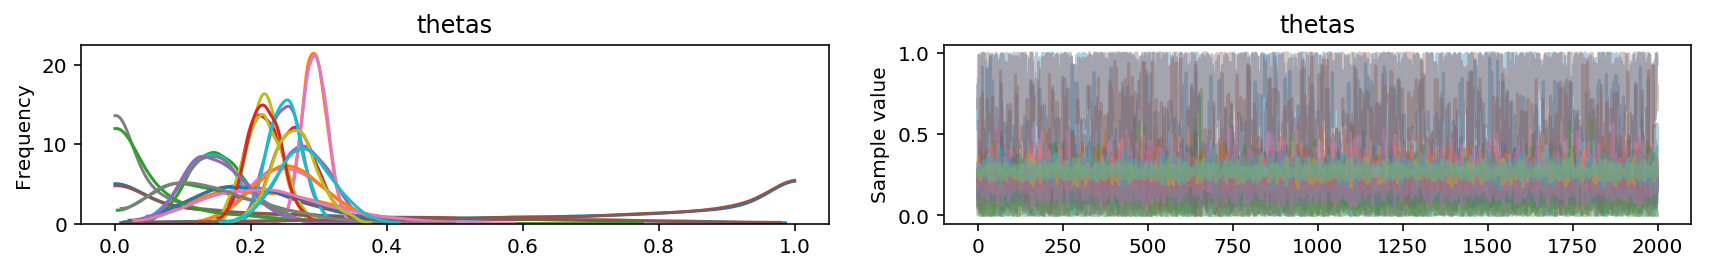

In [18]:
traceplot = pm.traceplot(baseline_trace)

Looks like convergence has been achieved. From a $Beta(\alpha=0.5, \beta=0.5)$ prior, those players for which we have only 1 data point have very wide posterior distribution estimates.

In [5]:
import theano.tensor as tt

with pm.Model() as baseball_model:
    
    phi = pm.Uniform('phi', lower=0.0, upper=1.0)
    kappa_log = pm.Exponential('kappa_log', lam=1.5)
    kappa = pm.Deterministic('kappa', tt.exp(kappa_log))

    thetas = pm.Beta('thetas', alpha=phi*kappa, beta=(1.0-phi)*kappa, shape=len(df))
    like = pm.Binomial('like', n=df['AB'], p=thetas, observed=df['H'])

INFO (theano.gof.compilelock): Refreshing lock /Users/ericmjl/.theano/compiledir_Darwin-17.6.0-x86_64-i386-64bit-i386-3.6.6-64/lock_dir/lock


In [6]:
with baseball_model:
    trace = pm.sample(2000, init='advi')

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO (theano.gof.compilelock): Refreshing lock /Users/ericmjl/.theano/compiledir_Darwin-17.6.0-x86_64-i386-64bit-i386-3.6.6-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/ericmjl/.theano/compiledir_Darwin-17.6.0-x86_64-i386-64bit-i386-3.6.6-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/ericmjl/.theano/compiledir_Darwin-17.6.0-x86_64-i386-64bit-i386-3.6.6-64/lock_dir/lock
Average Loss = 58.822:   5%|▌         | 10891/200000 [00:26<07:46, 405.66it/s]
Convergence archived at 10900
Interrupted at 10,899 [5%]: Average Loss = 154.52
INFO (theano.gof.compilelock): Refreshing lock /Users/ericmjl/.theano/compiledir_Darwin-17.6.0-x86_64-i386-64bit-i386-3.6.6-64/lock_dir/lock
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [thetas_logodds__, kappa_log_log__, phi_interval__]
100%|██████████| 2500/2500 [00:33<00:00, 73.82it/s]
There were 1 divergences after tuning. Increase `target_accep

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1f70ba20>,
      dtype=object)

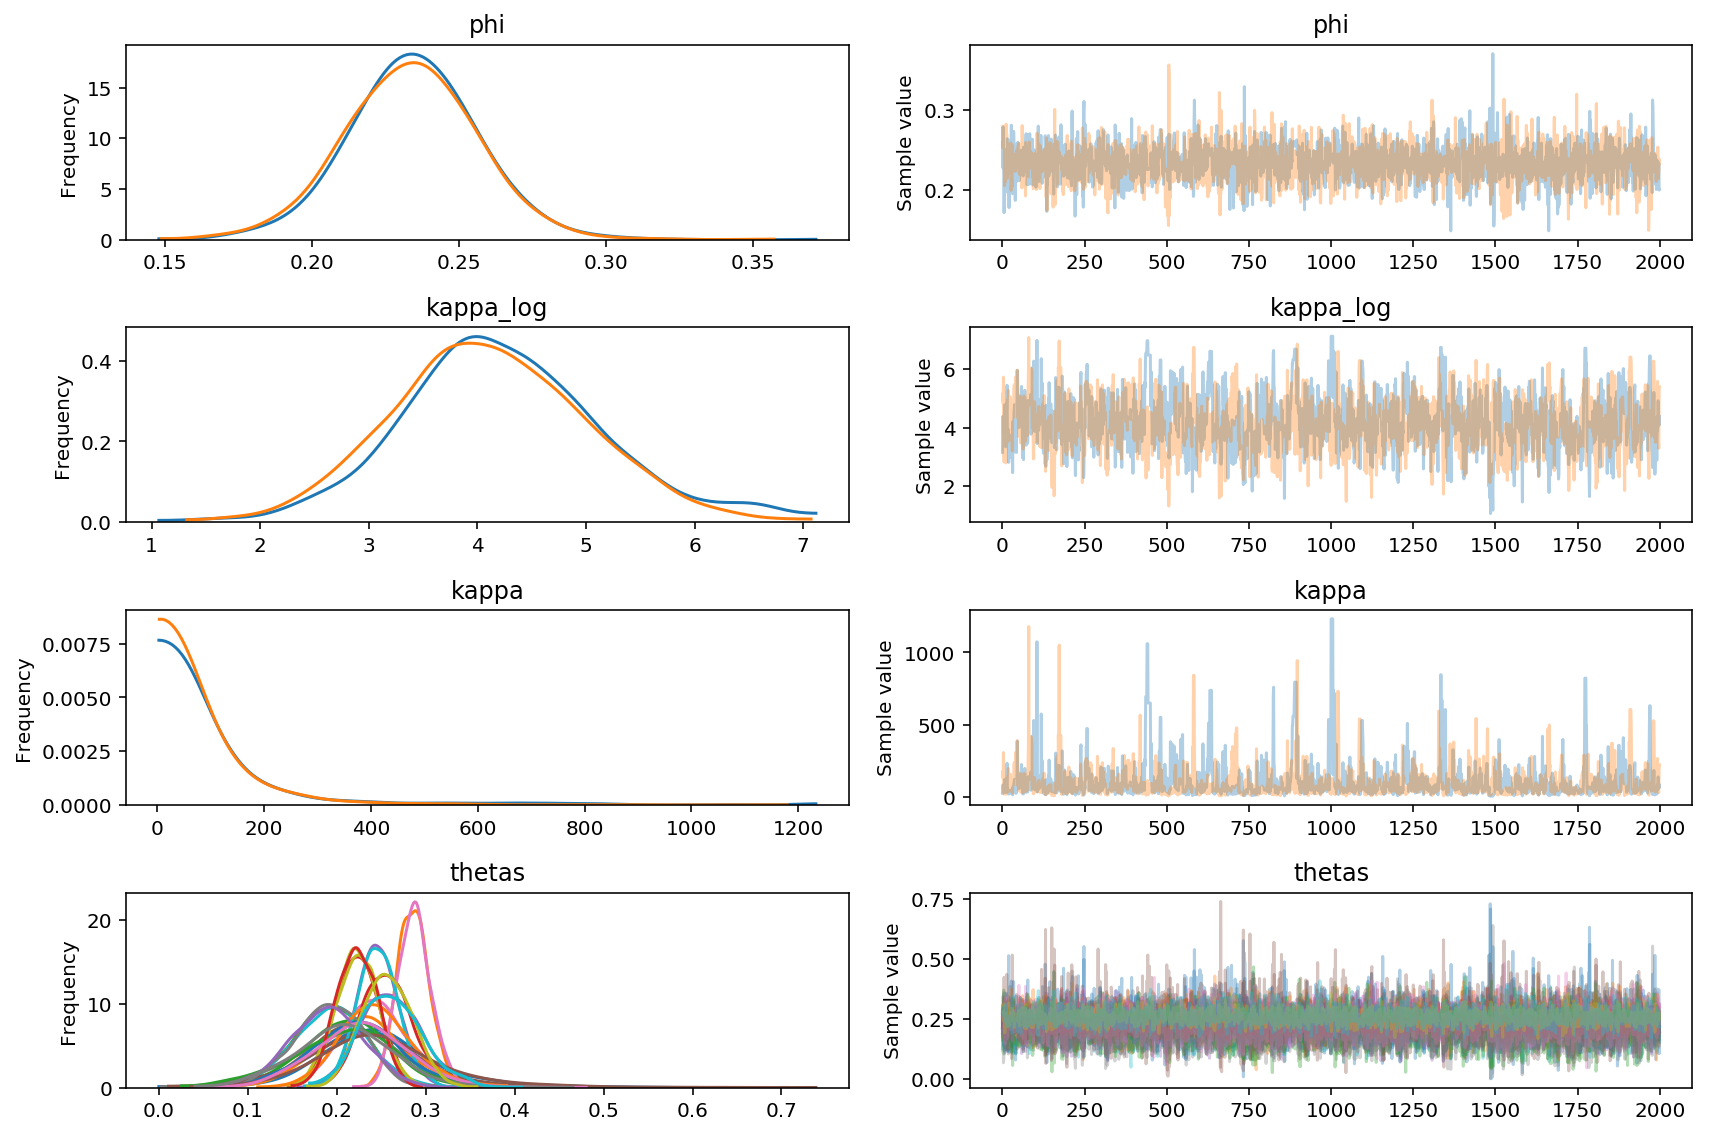

In [7]:
pm.traceplot(trace)

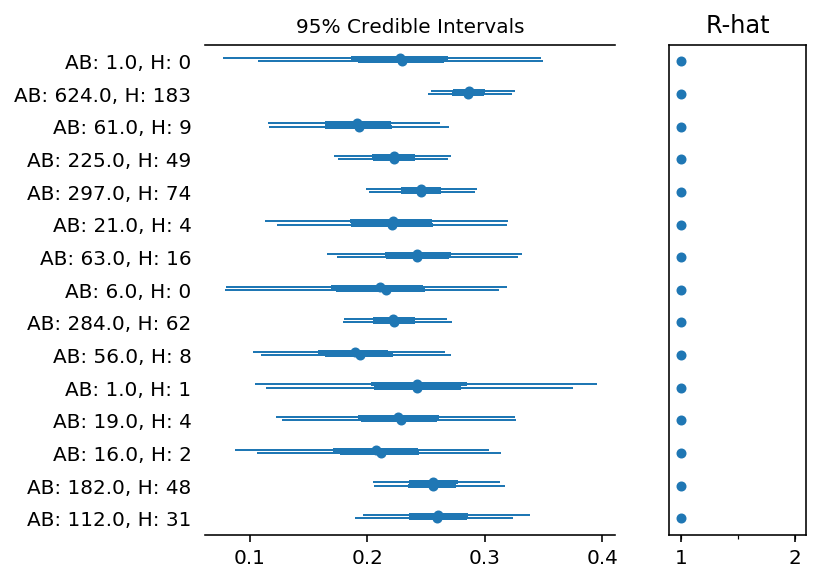

In [9]:
ylabels = 'AB: ' + df['AB'].astype(str) + ', H: ' + df['H'].astype('str')
pm.forestplot(trace, varnames=['thetas'], ylabels=ylabels)